## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusions)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
np.random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

the timestamp coulmn is an object column, so I have to convert it into a datetime column <br>
Here is a usful link to convert an object column to a timestamp
https://stackoverflow.com/questions/50089903/convert-column-to-timestamp-pandas-dataframe

In [4]:
df['timestamp'] = pd.to_datetime(df.timestamp)

In [5]:
#now the column is a time stamp
df.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
dtype: object

**in order to get the duration we find the start and the end of our servey by finding the maximum and the minimum value in the times column**

In [6]:
start_date=df['timestamp'].max()
end_date=df['timestamp'].min()

In [7]:
#substract both dates to find the duration
duration=start_date-end_date
duration

Timedelta('21 days 23:59:49.081927')

b. Use the cell below to find the number of rows in the dataset.

In [8]:
print('number of rows in the dataset is '+str(df.shape[0]))

number of rows in the dataset is 294478


c. The number of unique users in the dataset.

In [9]:
print('unique users in the dataset is '+str(df['user_id'].nunique()))

unique users in the dataset is 290584


d. The proportion of users converted.

In [10]:
print('proportion of users converted is '+str(df['converted'].mean()))

proportion of users converted is 0.119659193556


e. The number of times the `new_page` and `treatment` don't match.

In [11]:
df.query("landing_page == 'new_page' and group == 'control'").shape[0]+ df.query("landing_page == 'old_page' and group == 'treatment'").shape[0]

3893

In [12]:
# or 
df.query("(landing_page == 'new_page' and group == 'control') or (landing_page == 'old_page' and group == 'treatment')").shape[0]

3893

f. Do any of the rows have missing values?

In [13]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**No null values in the dataset**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [14]:
df2=df.drop(df.query("(landing_page == 'new_page' and group == 'control') or (landing_page == 'old_page' and group == 'treatment')").index)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [16]:
df2.shape

(290585, 5)

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [17]:
print('The number of unique user_ids in df2 '+str(df2['user_id'].nunique()))

The number of unique user_ids in df2 290584


b. There is one **user_id** repeated in **df2**.  What is it?

 a usful link for how to deal with duplicated rows https://towardsdatascience.com/finding-and-removing-duplicate-rows-in-pandas-dataframe-c6117668631f

In [18]:
# df2.duplicated(subset=['user_id']).sum()
repeated_user=df2[df2.duplicated(subset=['user_id'])]
repeated_user.head()

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [19]:
# or by loc
df2.loc[df2['user_id'].duplicated(), :]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [20]:
df2=df2.drop(2893)

In [21]:
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [22]:
conversion_p=df2['converted'].mean()
print('conversion probability is '+str(conversion_p))

conversion probability is 0.119597087245


b. Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
control_p=df2.query("group == 'control'")['converted'].mean()
print('control group conversion probability is '+str(control_p))

control group conversion probability is 0.1203863045


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
treatment_p=df2.query("group == 'treatment'")['converted'].mean()
print('treatment group conversion probability is '+str(treatment_p))

treatment group conversion probability is 0.118808065515


d. What is the probability that an individual received the new page?

In [25]:
print('probability that an individual received the new page is '+str(df2.query("landing_page == 'new_page'").shape[0]/df2.shape[0]))

probability that an individual received the new page is 0.5000619442226688


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

the test was ran for only 22 days which I think it is not enough time to judge if the new page is effective than the old page. although the control group showed higher probability to convert (0.12>0.118), but it is not enough to reject the new page or even to continue with the old page

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_{0} : p_{new} =  p_{old}$$
$$H_{1} : p_{new} >  p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [26]:
conversion_rate=df2['converted'].mean()
print('conversion rate for  𝑝𝑛𝑒𝑤  under the null is '+str(conversion_rate))

conversion rate for  𝑝𝑛𝑒𝑤  under the null is 0.119597087245


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [27]:
# because they are equal each other under the null
conversion_rate=df2['converted'].mean()
print('conversion rate for 𝑝𝑜𝑙𝑑 under the null is '+str(conversion_rate))

conversion rate for 𝑝𝑜𝑙𝑑 under the null is 0.119597087245


c. What is $n_{new}$, the number of individuals in the treatment group?

In [28]:
nnew=df2.query("group == 'treatment'").shape[0]
print('number of individuals in the treatment group (nnew) is '+str(nnew))

number of individuals in the treatment group (nnew) is 145310


d. What is $n_{old}$, the number of individuals in the control group?

In [29]:
nold=df2.query("group == 'control'").shape[0]
print('number of individuals in the control group (nold) is '+str(nold))

number of individuals in the control group (nold) is 145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [30]:
new_page_converted = np.random.binomial(1, conversion_rate,nnew)
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [31]:
old_page_converted = np.random.binomial(1, conversion_rate,nold)
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [32]:
new_page_converted.mean()- old_page_converted.mean()

-0.0023973022979572739

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [33]:
p_diffs =[]

for _ in range(10000):
    old_page_conversion_rate = np.random.binomial(1, conversion_rate,nold).mean()
    new_page_conversion_rate = np.random.binomial(1, conversion_rate,nnew).mean()
    CR_diff = new_page_conversion_rate - old_page_conversion_rate
    p_diffs.append(CR_diff)
    

p_diffs = np.array(p_diffs)

In [34]:
p_diffs

array([ 0.00150527,  0.00114718, -0.00051134, ..., -0.00149595,
       -0.0005941 ,  0.00158072])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

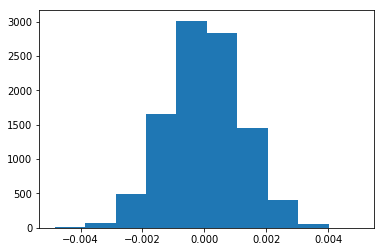

In [35]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [36]:
actual_difference = df.query("landing_page == 'new_page'")['converted'].mean() - df.query("landing_page == 'old_page'")['converted'].mean()

print('the actual difference observed in the original dataset is '+str(actual_difference)) 

the actual difference observed in the original dataset is -0.00163679459926


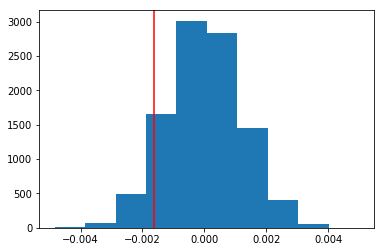

In [37]:
plt.hist(p_diffs);
plt.axvline(actual_difference, color='r');

In [38]:
prob_more_extreme_high = (actual_difference < p_diffs).mean()
prob_more_extreme_high

0.91610000000000003

In [39]:
#or by simulating a normal distribution using the standard deviation of the p_diffs
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

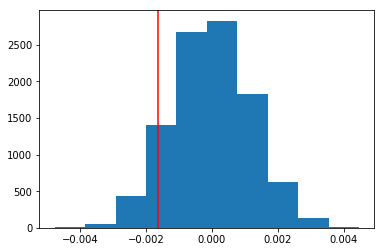

In [40]:
#Plot Null distribution
plt.hist(null_vals);
#Plot vertical line for observed statistic
plt.axvline(x=actual_difference,color ='red');

In [41]:
(null_vals > actual_difference).mean()

0.90980000000000005

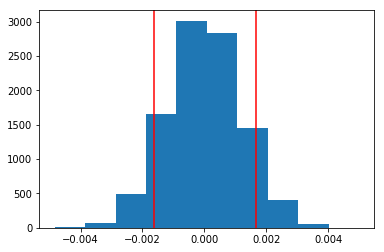

In [42]:
low_prob = (p_diffs < actual_difference).mean()

high_prob = (p_diffs.mean() + (p_diffs.mean() - actual_difference) < p_diffs).mean()

plt.hist(p_diffs);
plt.axvline(actual_difference, color='red');
plt.axvline(p_diffs.mean() + (p_diffs.mean() - actual_difference), color='red');

In [43]:
p_val = low_prob + high_prob
print(p_val)

0.1717


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?



**After calculating the P_valu, I found it higher than 0.05.  Hence, I accept the null hypothesis. and I think there is no difference between the new and old pages. in other language, the new updates in the landing page dosn't affect if an indivedual will convert or not**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [44]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
convert_old = df2.query("landing_page == 'old_page'")['converted'].sum()
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [45]:
z_score, p_value = sm.stats.proportions_ztest(([convert_new,convert_old]),([n_new,n_old]))

In [46]:
print("Z score: ",z_score)
print("P-Value: ", p_value)

Z score:  -1.31092419842
P-Value:  0.189883374482


In [47]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

In [48]:
print("Z score: ",z_score)
print("P-Value: ", p_value)

Z score:  -1.31092419842
P-Value:  0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**as it defiened in this [link](https://www.statisticshowto.com/probability-and-statistics/z-score/). the Z- score gives you an idea of how far from the mean a data point is. But more technically it’s a measure of how many standard deviations below or above the population mean a raw score is. 
and I found it to be  -1.31 which is less than thecritical 1.96 moreover, the p_value was found to be higher than 0.05. therefor, I have no reason to reject the null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [49]:
df2['intercept'] = 1
df2[['a_page', 'ab_page']] = pd.get_dummies(df2['group'])
# df2 = df2.drop('a_page', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,a_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [50]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [51]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-13 10:08 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**0.190 which is almost similar to the one that I got before in part II, The null hypothesis is that when ab_page = 1 (treatment) and converted = 0 (not converted); the alternative hypothesis is that when ab_page = 1 and converted is 1**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**of course there is other things we can add to test if it can improve our model, but we should be aware if there is a colinearity between other coulmns**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [52]:
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [53]:
country_df['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

## I have 3 countries in the country.csv, my plan is to drop the least country observed which is "CA" 

In [54]:
df_final=df2.merge(country_df, on='user_id', how='inner')
df_final.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
a_page          0
ab_page         0
country         0
dtype: int64

In [55]:
countries_dummies = pd.get_dummies(df_final['country'])
df_final = df_final.join(countries_dummies)

In [56]:
df_final.tail()

,user_id,timestamp,group,landing_page,converted,intercept,a_page,ab_page,country,CA,UK,US
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,1,0,US,0,0,1
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,1,0,US,0,0,1
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,1,0,US,0,0,1
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,1,0,US,0,0,1
290583,715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,0,1,UK,0,1,0


In [57]:
log_mod = sm.Logit(df_final['converted'], df_final[['intercept', 'ab_page', 'US', 'UK']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [58]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-13 10:08 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

## P_value is greater than 0.05 for all of our columns, so we still have to retain the null hypothesis 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [59]:
df_final['UK_ab_page'] = df_final['UK']*df_final['ab_page']
df_final['CA_ab_page'] = df_final['CA']*df_final['ab_page']
df_final.head()

,user_id,timestamp,group,landing_page,converted,intercept,a_page,ab_page,country,CA,UK,US,UK_ab_page,CA_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0,0


In [60]:
logit3 = sm.Logit(df_final['converted'], df_final[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])

results = logit3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-13 10:08 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

## P_value is greater than 0.05 for  the interaction between a country and whether the subject is in the treatment or in control group a so we still have to accept the null hypothesis 

<a id='conclusions'></a>
## Conclusions

in this notebook, I tested if the new landing page perform better in conversion rate for user than the old page, at first the company devided its user into two groups, one group was a control group (who had the old landing page) and the other group was the treatment group (who recived the new landing page).  I tested different method and different approchs to evalute the model. <br>
There were no statestical significance if the new page perform better using both p_value and using the logestic regression. in other words, no statestical evidence that the user will convert if they recived the new landing page.
In addition, I added the country for each user and tested if there is a statestical evidence that the country of residence  might affect the conversion rate, but there were no statestical evidence that the user might convert due to his geographic location.<br>
there are plenty of other things that needed to be tested, for example:<br>
1- what is the effect of the gender of the user on the conversion rate.<br>
2- what is the effect of user age on the conversion rate. (as younger generations love to explore new ideas hence, they migh convert with the new page)<br>
3- is this user is a new user or an old user of this platform. (as old user won't like these changes on their pages while new users won't notice the difference. therefor they are more likely will convert)<br>

In [61]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0